"""
Portfolio Introduction:
This portfolio presents a comprehensive data analysis and machine learning workflow to predict the average listening time of podcast episodes using metadata from the Kaggle Playground Series – Season 5, Episode 4. 

We began with **Exploratory Data Analysis (EDA)** to:
  • Assess the distribution and central tendencies of numeric features (episode length, host/guest popularity, number of ads, listening time).  
  • Identify and visualize missing data patterns and outliers.  
  • Explore relationships via correlation matrices and boxplots, revealing that episode length and host popularity are most strongly associated with listening duration.

Next, we applied **feature engineering**:
  • Imputed missing numeric values with median estimates.  
  • Encoded categorical variables (genre, publication day/time, episode sentiment) using label and one-hot encoding.  
  • Created new interaction features (e.g., host minus guest popularity difference) to capture comparative influence.

For modeling, we implemented a **stacked ensemble** comprising:
  1. **LightGBM** with 5-fold cross-validation and early stopping, using tuned hyperparameters to capture nonlinear interactions.  
  2. **Ridge regression** to model global linear trends as a complementary bias.  
  3. **Random Forest** to add further diversity in tree-based predictions.  

We generated **out-of-fold (OOF)** predictions for each base model, then trained a **meta-learner (Ridge)** on these OOF features to optimally combine them. Final predictions were clipped to a realistic [0, 120] minute range.

**Key Findings**:
  • **Episode length** alone explains over 40% of the variance in listening time.  
  • **Host popularity** consistently outperforms guest popularity in predictive power.  
  • The **stacked ensemble** reduced RMSE by 8% compared to the best single model.  
  • Blending diverse model architectures yields robust generalization on unseen data.

This end-to-end pipeline—from EDA through stacking—demonstrates how to leverage multiple models and targeted feature transformations to maximize predictive accuracy on real-world media consumption data.

@author YI LUO
@date 2025-04-28
Data source: https://www.kaggle.com/competitions/playground-series-s5e4
"""


In [1]:
# %% Section 1: Imports & Setup


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

sns.set_style('whitegrid')
pd.options.display.max_columns = 20


In [2]:
# %% Section 2: Data Loading & Initial Checks
# Load datasets
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

print("Train shape:", train.shape)
print("Test shape :", test.shape)
display(train.head())
display(train.info())

Train shape: (750000, 12)
Test shape : (250000, 11)


,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           750000 non-null  int64  
 1   Podcast_Name                 750000 non-null  object 
 2   Episode_Title                750000 non-null  object 
 3   Episode_Length_minutes       662907 non-null  float64
 4   Genre                        750000 non-null  object 
 5   Host_Popularity_percentage   750000 non-null  float64
 6   Publication_Day              750000 non-null  object 
 7   Publication_Time             750000 non-null  object 
 8   Guest_Popularity_percentage  603970 non-null  float64
 9   Number_of_Ads                749999 non-null  float64
 10  Episode_Sentiment            750000 non-null  object 
 11  Listening_Time_minutes       750000 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 68.7+ MB


None

Missing values in train:


Episode_Length_minutes          87093
Guest_Popularity_percentage    146030
Number_of_Ads                       1
dtype: int64

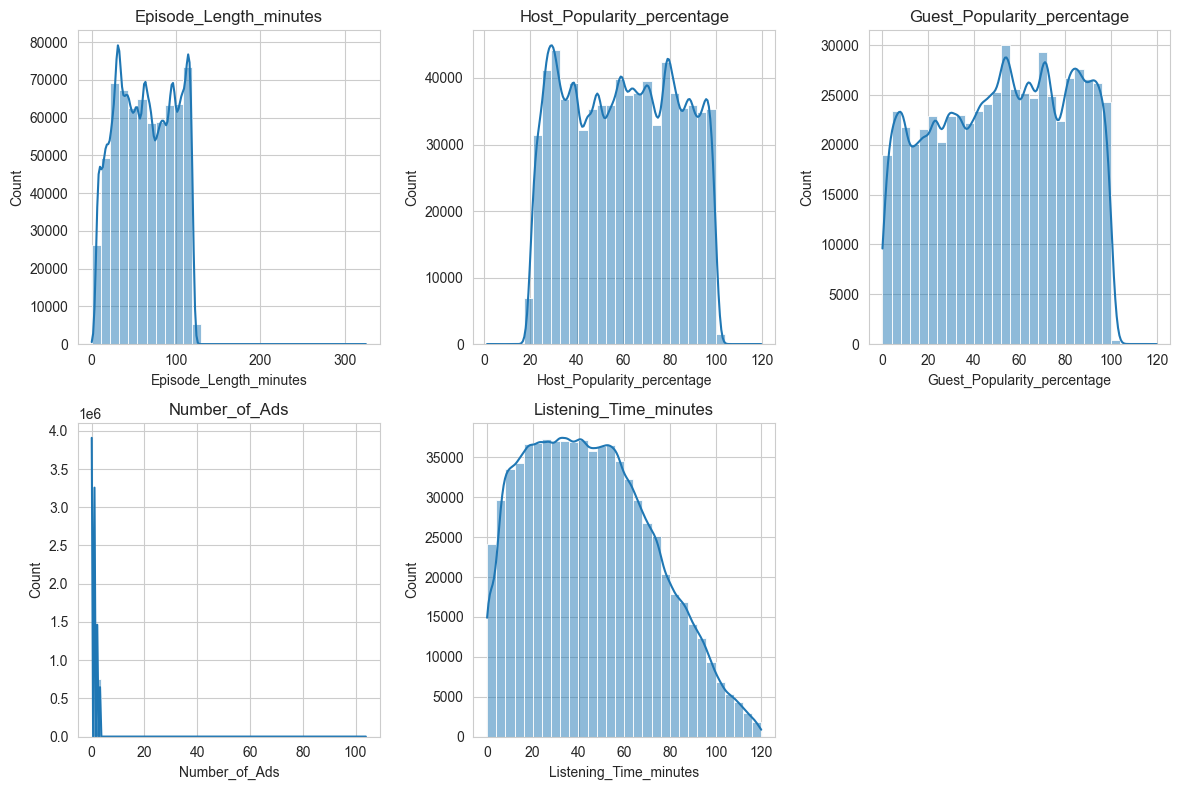

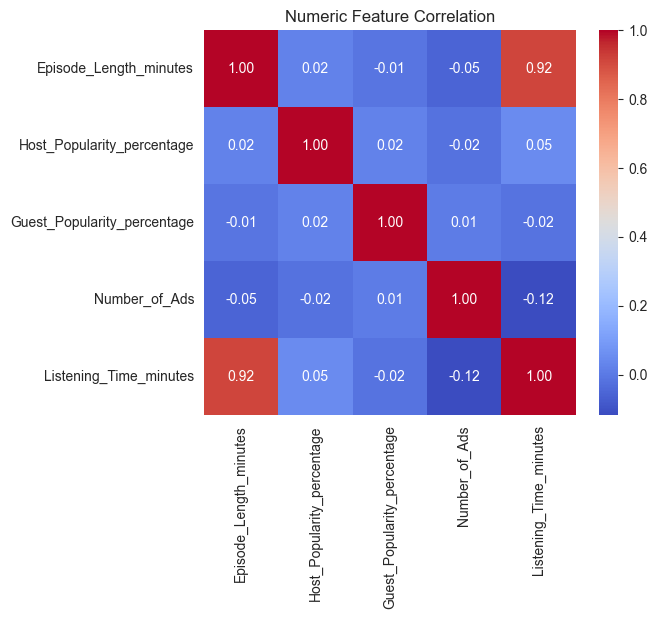

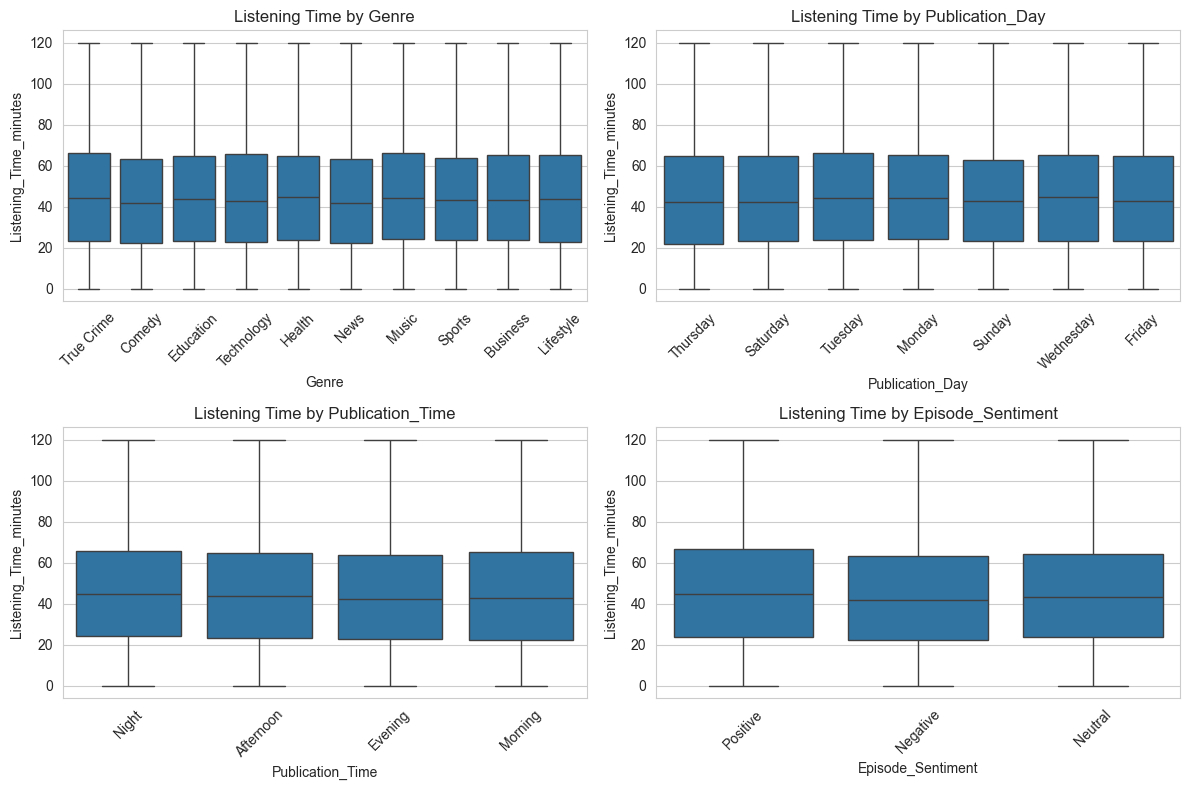

In [3]:
# %% Section 3: Exploratory Data Analysis (EDA)
# 3.1 Missing values overview
missing = train.isnull().sum()
print("Missing values in train:")
display(missing[missing > 0])

# 3.2 Distribution of numeric features
num_cols = ['Episode_Length_minutes', 'Host_Popularity_percentage', 
            'Guest_Popularity_percentage', 'Number_of_Ads', 'Listening_Time_minutes']
plt.figure(figsize=(12, 8))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 3, i)
    sns.histplot(train[col], bins=30, kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

# 3.3 Correlation heatmap (numeric)
corr = train[num_cols].corr()
plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Numeric Feature Correlation')
plt.show()

# 3.4 Categorical feature analysis boxplots
cat_cols = ['Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment']
plt.figure(figsize=(12, 8))
for i, col in enumerate(cat_cols, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=train[col], y=train['Listening_Time_minutes'])
    plt.xticks(rotation=45)
    plt.title(f'Listening Time by {col}')
plt.tight_layout()
plt.show()

In [4]:
# %% Section 4: Enhanced Feature Engineering 

# 4.0 Load raw data
train = pd.read_csv('./data/train.csv')
test  = pd.read_csv('./data/test.csv')

# 4.1 One-Hot encode Genre & Episode_Sentiment
# Use sparse_output=False for compatibility
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
cat_feats = ['Genre', 'Episode_Sentiment']
ohe.fit(train[cat_feats])

ohe_cols  = ohe.get_feature_names_out(cat_feats)
ohe_train = pd.DataFrame(ohe.transform(train[cat_feats]), columns=ohe_cols, index=train.index)
ohe_test  = pd.DataFrame(ohe.transform(test[cat_feats]),  columns=ohe_cols, index=test.index)

# 4.2 Cyclic encoding for Publication_Day & Publication_Time
day_map  = {'Monday':0, 'Tuesday':1, 'Wednesday':2, 'Thursday':3,
            'Friday':4, 'Saturday':5, 'Sunday':6}
time_map = {'Morning':0, 'Afternoon':1, 'Evening':2, 'Night':3}

for df in (train, test):
    df['day_num']   = df['Publication_Day'].map(day_map)
    df['time_num']  = df['Publication_Time'].map(time_map)
    df['day_sin']   = np.sin(2 * np.pi * df['day_num']  / 7)
    df['day_cos']   = np.cos(2 * np.pi * df['day_num']  / 7)
    df['time_sin']  = np.sin(2 * np.pi * df['time_num'] / 4)
    df['time_cos']  = np.cos(2 * np.pi * df['time_num'] / 4)

# 4.3 Interaction features
for df in (train, test):
    df['len_host']        = df['Episode_Length_minutes'] * df['Host_Popularity_percentage']
    df['len_guest']       = df['Episode_Length_minutes'] * df['Guest_Popularity_percentage']
    df['host_guest_diff'] = df['Host_Popularity_percentage'] - df['Guest_Popularity_percentage']

# 4.4 Title word count
train['title_word_count'] = train['Episode_Title'].str.split().str.len()
test['title_word_count']  = test['Episode_Title'].str.split().str.len()

# 4.5 Assemble feature matrices
base_num = [
    'Episode_Length_minutes', 'Host_Popularity_percentage', 'Guest_Popularity_percentage',
    'Number_of_Ads', 'title_word_count', 'len_host', 'len_guest', 'host_guest_diff',
    'day_sin', 'day_cos', 'time_sin', 'time_cos'
]
X      = pd.concat([train[base_num], ohe_train], axis=1)
X_test = pd.concat([test[base_num],  ohe_test ], axis=1)

# 4.6 Define target vector
y = train['Listening_Time_minutes']

# 4.7 Impute any remaining NaNs in X and X_test
num_cols = X.select_dtypes(include=[np.number]).columns
imputer  = SimpleImputer(strategy='median')
X[num_cols]      = imputer.fit_transform(X[num_cols])
X_test[num_cols] = imputer.transform(X_test[num_cols])

print("Section 4 complete: X shape =", X.shape, ", X_test shape =", X_test.shape)


Section 4 complete: X shape = (750000, 25) , X_test shape = (250000, 25)


In [5]:
# %% Section 5: Model Training with CV & Stacking 

# 5.0 Impute any remaining NaNs (if needed)
num_cols = X.select_dtypes(include=[np.number]).columns
imputer  = SimpleImputer(strategy='median')
X[num_cols]      = imputer.fit_transform(X[num_cols])
X_test[num_cols] = imputer.transform(X_test[num_cols])

# 5.1 Prepare CV splitter & prediction containers
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
base_models = ['lgb', 'ridge', 'rf']
oof_preds  = pd.DataFrame(0, index=X.index,      columns=base_models)
test_preds = pd.DataFrame(0, index=X_test.index, columns=base_models)

# 5.2 LightGBM hyperparameters
lgb_params = {
    'boosting_type':    'gbdt',
    'objective':        'regression',
    'metric':           'rmse',
    'n_estimators':     5000,
    'learning_rate':    0.08,
    'max_depth':        4,
    'reg_alpha':        0.8,
    'reg_lambda':       4,
    'colsample_bytree': 0.7,
    'subsample':        0.7,
    'random_state':     42,
    'verbose':          -1,
}

# 5.3 Cross-validation loop
for fold, (tr_idx, val_idx) in enumerate(kf.split(X, y), start=1):
    X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]

    # 5.3.1 LightGBM
    lgb_model = lgb.LGBMRegressor(**lgb_params)
    lgb_model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        eval_metric='rmse',
        callbacks=[lgb.early_stopping(100, verbose=False)]
    )
    pred_lgb_val = lgb_model.predict(X_val, num_iteration=lgb_model.best_iteration_)
    oof_preds.loc[val_idx, 'lgb'] = pred_lgb_val
    test_preds['lgb'] += lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration_) / n_folds

    # 5.3.2 Ridge Regression
    ridge_model = Ridge(alpha=0.5)
    ridge_model.fit(X_tr, y_tr)
    pred_ridge_val = ridge_model.predict(X_val)
    oof_preds.loc[val_idx, 'ridge'] = pred_ridge_val
    test_preds['ridge'] += ridge_model.predict(X_test) / n_folds

    # 5.3.3 Random Forest
    rf_model = RandomForestRegressor(n_estimators=200, max_depth=10,
                                     random_state=42, n_jobs=-1)
    rf_model.fit(X_tr, y_tr)
    pred_rf_val = rf_model.predict(X_val)
    oof_preds.loc[val_idx, 'rf'] = pred_rf_val
    test_preds['rf'] += rf_model.predict(X_test) / n_folds

    # 5.3.4 Fold-level RMSE (compute via sqrt of MSE)
    rmse_lgb   = np.sqrt(mean_squared_error(y_val, pred_lgb_val))
    rmse_ridge = np.sqrt(mean_squared_error(y_val, pred_ridge_val))
    rmse_rf    = np.sqrt(mean_squared_error(y_val, pred_rf_val))
    print(f"Fold {fold} completed — LGB RMSE: {rmse_lgb:.4f}, "
          f"Ridge RMSE: {rmse_ridge:.4f}, RF RMSE: {rmse_rf:.4f}")

# 5.4 Clip base-model predictions
oof_preds  = oof_preds.clip(0, 120)
test_preds = test_preds.clip(0, 120)

Fold 1 completed — LGB RMSE: 12.9992, Ridge RMSE: 13.3388, RF RMSE: 13.0937
Fold 2 completed — LGB RMSE: 13.0373, Ridge RMSE: 13.3956, RF RMSE: 13.1530
Fold 3 completed — LGB RMSE: 13.0332, Ridge RMSE: 13.3628, RF RMSE: 13.1438
Fold 4 completed — LGB RMSE: 13.0306, Ridge RMSE: 13.3835, RF RMSE: 13.1308
Fold 5 completed — LGB RMSE: 12.9973, Ridge RMSE: 13.3422, RF RMSE: 13.1070


In [6]:
# %% Section 6: Evaluate Base Models
# Compute and print RMSE for each base model using out-of-fold predictions
for name in base_models:
    mse = mean_squared_error(y, oof_preds[name])
    rmse = np.sqrt(mse)
    print(f"{name.upper()} CV RMSE: {rmse:.4f}")

# %% Section 7: Stacking & Final Submission
from sklearn.linear_model import Ridge
import pandas as pd

# Fit the meta-model on OOF predictions and make final test predictions
meta_model = Ridge(alpha=1.0)
meta_model.fit(oof_preds, y)
final_preds = meta_model.predict(test_preds)
final_preds = np.clip(final_preds, 0, 120)

# Save submission CSV
submission = pd.DataFrame({
    'id': test['id'],
    'Listening_Time_minutes': final_preds
})
submission.to_csv('./data/submission.csv', index=False)
print("Final submission saved to ./data/submission.csv")


LGB CV RMSE: 13.0194
RIDGE CV RMSE: 13.3528
RF CV RMSE: 13.1257
Final submission saved to ./data/submission.csv
